In [1]:
import math, random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F
from torch.autograd import Variable

from torch.nn.utils import clip_grad_value_
from time import sleep

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
class QLearningAgent:
    
    def __init__(self, state_dim, action_dim, hidden_sizes = [128,128], gamma = 1,
                 epsilon = 0.5, buffer_size = 10**5, batch_size = 2**10):
        
        self.nn  = torch.nn.Sequential()
        cur_dim = state_dim
        for i,hid_dim in enumerate(hidden_sizes):
            self.nn.add_module(f'Linear_{i}',torch.nn.Linear(cur_dim,hid_dim))
            self.nn.add_module(f'Relu_{i}',torch.nn.ReLU())
            cur_dim = hid_dim
        self.nn.add_module('out',torch.nn.Linear(cur_dim,action_dim))

        
        self.optim = torch.optim.Adam(self.nn.parameters())
        self.gamma = gamma
        self.epsilon = epsilon
        self.buffer = []
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.action_dim = action_dim
        self.min_epsilon = 0.01
        
    def get_action(self, state, epsilon = None):
        '''
        Make action on state. Explore with epsilon rate
        '''
        if not epsilon:
            epsilon =  self.epsilon
        if np.random.rand() < epsilon:
            action = np.random.choice(self.action_dim)
        else:
            q_values = self.nn(Variable(torch.Tensor(state)))        
            action = q_values.argmax().data.numpy().item()
           
        return action
    
    def decrease_exploration_rate(self, decay):
        self.epsilon = max(self.epsilon*decay, self.min_epsilon)
        
    def update_buffer(self,data):
        assert all(len(e)==5 for e in data), 'Buffer accepts only lists of (s,a,r,s1,d) tuples'
        self.buffer = (self.buffer + data)[-self.buffer_size:]
    
    def sample_from_buffer(self, size):
        idx = np.random.choice(len(self.buffer),size,replace = False)
        return [self.buffer[i] for i in idx]
    
    def train_step(self):
        ''' 
        Make agent train step
        '''
        batch = self.sample_from_buffer(self.batch_size)
        sn      = Variable(torch.Tensor([r[0] for r in batch]))  # States batch
        an      = torch.LongTensor([[r[1]] for r in batch])      # Actions batch
        rn      = torch.Tensor([r[2] for r in batch])            # Rewards batch
        s_nextn = Variable(torch.Tensor([r[3] for r in batch]))  # Next states batch
        done = torch.Tensor([float(r[4]) for r in batch]) # Next state is not terminal flag batch
        
        # Mask from actions to apply on model output
        a_maskn = torch.zeros(self.batch_size,self.action_dim).scatter_(1, an, 1).byte()  
        max_next_q_valn = (self.nn(s_nextn)).max(dim=1)[0].data  # max target q-values for next states
        q_valn =  self.nn(sn)  # work nn q-values for curr states
        loss = ((q_valn[a_maskn] - Variable(rn + self.gamma * max_next_q_valn * (1 - done)))**2).mean()
        # Train nn
        self.nn.zero_grad()
        loss.backward()
#         clip_grad_value_(self.nn.parameters(),10**2)
        self.optim.step()
        
        return loss

In [4]:
def show_agent_play(env_name, agent, eps):
    '''
    Визуализация поведения в gym среде с названием env_name 
    агента agent по эпсилон-жадной стратегии с заданным eps.
    Функция возвращает сумарный reward показанного эпизода.
    '''
    env = gym.make(env_name)
    env._max_episode_steps = 1000
    s = env.reset()
    env.render()
    sleep(1)
    done = False
    episode_reward = 0
    while done != True:
        a = agent.get_action(s, epsilon=eps)
        s2, r, done, info = env.step(a)
        episode_reward += r
        env.render()
        s = s2
        sleep(0.01)
    env.close()
    return episode_reward

<h2>Deep Q Network</h2>

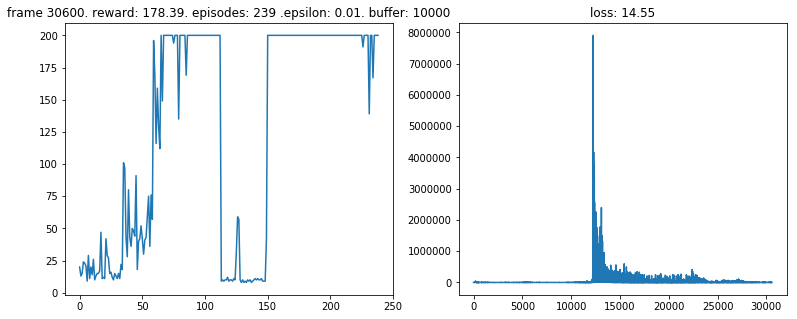

solved for 140 episodes


In [5]:
env = gym.make('CartPole-v0')
env._max_episode_steps = 200

rewards_log, counters_log = [], []
    
#     if(np.mean(rewards_log[-10:])>reward_success_threshold):
#         print(f'\nSuccess. We learnt the game with {reward_success_threshold} reward threshold.')
#         break
        
num_frames = 100000
batch_size = 2**5
gamma      = 1
hidden_sizes = [2**7,2**7] # Количество нейронов в скрытом слое
# batch_size = 1000 # Размер батча для обучения
buffer_size = 10**4 # Размер буфера для обучения
init_epsilon = 1
exploration_decay = 0.999 # Снижение epsilon на каждом шаге
reward_success_threshold = 180

losses = []
all_rewards = []
episode_reward = 0

agent = QLearningAgent(state_dim = env.observation_space.shape[0],
                       action_dim = env.action_space.n, 
                       hidden_sizes = hidden_sizes, 
                       gamma = gamma, 
#                        alpha = alpha, 
                       epsilon = init_epsilon, 
                       buffer_size = buffer_size,
                       batch_size = batch_size)

state = env.reset()
for frame_idx in range(1, num_frames + 1):
    agent.decrease_exploration_rate(exploration_decay)
    action = agent.get_action(state)
    
    next_state, reward, done, _ = env.step(action)
    agent.update_buffer([(state,action,reward,next_state,done)])
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        if np.mean(all_rewards[-100:]) > reward_success_threshold:
            print(f'solved for {len(all_rewards) - 100} episodes')
            break
        
    if len(agent.buffer) > batch_size:
        loss = agent.train_step()
        losses.append(loss.item())
        
    if frame_idx % 200 == 0:
        clear_output(True)
        plt.figure(figsize=(20,5))
        plt.subplot(131)
        plt.title('frame %s. reward: %.2f. episodes: %s .epsilon: %.2f. buffer: %d' % (frame_idx, 
                                                                       np.mean(all_rewards[-100:]), 
                                                                                     len(all_rewards),
                                                                       agent.epsilon, 
                                                                       len(agent.buffer)))
        plt.plot(all_rewards)
        plt.subplot(132)
        plt.title(f'loss: {losses[-1]:.2f}')
        plt.plot(losses)
        plt.show()

In [6]:
np.mean(all_rewards[-100:])

180.29

In [7]:
for _ in range(2):
    print(f"Reward in eval mode {show_agent_play('CartPole-v0',agent,0)}")

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Reward in eval mode 430.0
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Reward in eval mode 203.0


Домашнее задание.

*  добавить double target network (**3 балла**)
*  решить задачу при reward_success_threshold = 500 и env._max_episode_steps = 1000 (**3 балла**)
*  [Acrobot-v1](https://gym.openai.com/envs/Acrobot-v1/) до скора -120 (**4 балла**)
*  решить [CartPole-v0](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html) только по картинке, используя сверточную нейронную сеть (**5 баллов**)

<p><hr></p>